In [179]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import os

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
from transformers import BertTokenizer
from torchvision import models

from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

from peft import get_peft_model, LoraConfig, TaskType

import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


In [180]:
train_df = pd.read_csv("../data/fakeddit_train.tsv", sep = "\t")
val_df = pd.read_csv("../data/fakeddit_val.tsv", sep = "\t")
test_df = pd.read_csv("../data/fakeddit_test.tsv", sep = "\t")
#images in images folder with name: f"{id}.jpg"


print(train_df.head())

print(train_df.columns)
print(train_df.head())


In [181]:
# tokenize titles for BERT
def tokenize_titles(df, column_name='clean_title', max_length=256, device='cpu'):

    titles = df[column_name].astype(str).tolist()

    # use BERT tokenizer
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_encoded = bert_tokenizer(
        titles,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

    return df, bert_encoded

# tokenize for train, validation and test sets
train_df, train_bert_tokens = tokenize_titles(train_df)
val_df, val_bert_tokens = tokenize_titles(val_df)
test_df, test_bert_tokens = tokenize_titles(test_df)

Text & Image pytorch dataset
Text only pytorch dataset
Image only pytorch dataset

In [182]:
class NewsMultimodalDataset(Dataset):
    """Return dict: input_ids, attention_mask, image, label"""
    def __init__(self, df, tokenizer, transform, img_dir="../data/images", max_len=32):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.transform = transform
        self.img_dir = img_dir
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        title = str(row['clean_title']) if 'clean_title' in row.index else ""
        # ensure label is Python int
        label = int(row['3_way_label'])

        # Text tokenization
        tokens = self.tokenizer(
            title,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        input_ids = tokens['input_ids'].squeeze(0)
        attention_mask = tokens['attention_mask'].squeeze(0)

        # Image loading
        image_path = os.path.join(self.img_dir, f"{row['id']}.jpg")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image) 

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'image': image,
            'label': torch.tensor(label, dtype=torch.long)
        }

class TextOnlyDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=32):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        title = str(row['clean_title']) if 'clean_title' in row.index else ""
        label = int(row['3_way_label'])
        tokens = self.tokenizer(
            title,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': tokens['input_ids'].squeeze(0),
            'attention_mask': tokens['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

class ImageOnlyDataset(Dataset):
    def __init__(self, df, transform, img_dir="../data/images"):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        label = int(row['3_way_label'])
        image_path = os.path.join(self.img_dir, f"{row['id']}.jpg")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        return {
            'image': image,
            'label': torch.tensor(label, dtype=torch.long)
        }


Dataloader

In [183]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# text dataset to dataloader
train_text = TextOnlyDataset(train_df, tokenizer)
val_text = TextOnlyDataset(val_df, tokenizer)
test_text = TextOnlyDataset(test_df, tokenizer)

train_text_loader = DataLoader(train_text, batch_size=16, shuffle=True)
val_text_loader = DataLoader(val_text, batch_size=16, shuffle=True)
test_text_loader = DataLoader(test_text, batch_size=16, shuffle=True)

# image dataset to dataloader
train_image = ImageOnlyDataset(train_df, transform)
val_image = ImageOnlyDataset(val_df, transform)
test_image = ImageOnlyDataset(test_df, transform)

train_image_loader = DataLoader(train_image, batch_size=16, shuffle=True)
val_image_loader = DataLoader(val_image, batch_size=16, shuffle=True)
test_image_loader = DataLoader(test_image, batch_size=16, shuffle=True)

# text and image dataset to loade
train_ds = NewsMultimodalDataset(train_df, tokenizer, transform)
val_ds = NewsMultimodalDataset(val_df, tokenizer, transform)
test_ds = NewsMultimodalDataset(test_df, tokenizer, transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

BERT + RESNET & Fusion
late/feature fusion: Extract separate embeddings from each modality, then concatenate them before classification.

BERT model

In [184]:

class TextClassifier(nn.Module):
    def __init__(self, text_model_name="bert-base-uncased", num_labels=3, freeze_bert=False):
        super().__init__()
        self.bert = BertModel.from_pretrained(text_model_name)
        self.config = self.bert.config  
        hidden = self.bert.config.hidden_size
        self.classifier = nn.Linear(hidden, num_labels)

        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        return self.classifier(pooled)

# LoRA config
config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    r=8,
    lora_alpha=32,
    lora_dropout=0.2,
    target_modules=["query", "value"]
)

# apply LoRA to BERT first, not to classifier
bert = BertModel.from_pretrained("bert-base-uncased")
bert = get_peft_model(bert, config)

# wrap the LoRA-BERT in classifier
text_model = TextClassifier(num_labels=3)
text_model.bert = bert


ResNet model

In [185]:
class ImageClassifier(nn.Module):
    def __init__(self, num_labels=3):
        super().__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        in_feat = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_feat, num_labels)
        )
        
        # Freeze all params
        for p in self.backbone.parameters():
            p.requires_grad = False

        # Unfreeze last residual block
        for name, p in self.backbone.layer4.named_parameters():
            p.requires_grad = True
        # Unfreeze final classifier
        for p in self.backbone.fc.parameters():
            p.requires_grad = True

    def forward(self, image):
        return self.backbone(image)


Fusion of BERT and ResNet

In [186]:
class BertResNetLateFusion(nn.Module):
    def __init__(self, 
                 text_model_path="bert_text_only.pt", 
                 image_model_path="resnet_image_only.pt", 
                 num_classes=3, 
                 freeze_encoders=True):
        super().__init__()
        self.text_dropout = nn.Dropout(0.2)  
        self.img_dropout = nn.Dropout(0.2)

        # Load pretrained BERT
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.text_fc = nn.Linear(768, 512)  # reduce to 512-dim

        if text_model_path:
            try:
                text_state = torch.load(text_model_path, map_location="cpu")
                # Load only BERT weights (not classifier)
                bert_weights = {k.replace('bert.', ''): v for k, v in text_state.items() if 'bert.' in k}
                self.bert.load_state_dict(bert_weights, strict=False)
                print("Loaded pretrained BERT weights")
            except Exception as e:
                print(f"Could not load BERT weights: {e}")

        # Load pretrained ResNet
        resnet = models.resnet50(weights=None)
        resnet.fc = nn.Identity()
        self.resnet = resnet
        self.img_fc = nn.Linear(2048, 512)

        if image_model_path:
            try:
                image_state = torch.load(image_model_path, map_location="cpu")
                resnet_weights = {k.replace('resnet.', ''): v for k, v in image_state.items() if 'resnet.' in k}
                self.resnet.load_state_dict(resnet_weights, strict=False)
                print("Loaded pretrained ResNet weights")
            except Exception as e:
                print(f"Could not load ResNet weights: {e}")

        # Freeze fine-tuned encoders
        if freeze_encoders:
            for p in self.bert.parameters():
                p.requires_grad = False
            for p in self.resnet.parameters():
                p.requires_grad = False

            # Unfreeze last layers
            for name, param in self.bert.named_parameters():
                if "encoder.layer.11" in name or "pooler" in name:
                    param.requires_grad = True

            for name, param in self.resnet.named_parameters():
                if "layer4" in name:
                    param.requires_grad = True

        # Fusion head
        self.alpha = nn.Parameter(torch.tensor(0.5))  # learnable fusion weight
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    # Forward pass
    def forward(self, input_ids, attention_mask, image):
        # Text embedding
        text_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_emb = self.text_fc(text_out.pooler_output)
        text_emb = self.text_dropout(text_emb)

        # Image embedding
        img_emb = self.img_fc(self.resnet(image))
        img_emb = self.img_dropout(img_emb)

        # Weighted fusion
        fused_emb = self.alpha * text_emb + (1 - self.alpha) * img_emb
        logits = self.classifier(fused_emb)
        return logits



train model: prob here preds n truth part i think

Train BERT text model - 2e-5 overfits

In [187]:
def evaluate_text_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_p.extend(preds.cpu().numpy())
            all_l.extend(batch["label"].cpu().numpy())
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1


In [202]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []

def train_text_model(model, train_loader, val_loader, epochs=5, lr=1e-6): # decreased learning rate
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}")
        
        vloss, vacc, vf1 = evaluate_text_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, F1: {vf1:.4f}")
    return model


In [203]:

text_model = TextClassifier().to(device)
text_model = train_text_model(text_model, train_text_loader, val_text_loader)

Epoch 1: 100%|██████████| 1886/1886 [23:02<00:00,  1.36it/s]


Epoch 1 | Train Loss: 0.7095, Accuracy: 0.6736, F1: 0.6527
Validation Loss: 0.5975, Accuracy: 0.7370, F1: 0.7200


Epoch 2: 100%|██████████| 1886/1886 [22:29<00:00,  1.40it/s]


Epoch 2 | Train Loss: 0.5527, Accuracy: 0.7573, F1: 0.7490
Validation Loss: 0.5050, Accuracy: 0.7831, F1: 0.7794


Epoch 3: 100%|██████████| 1886/1886 [22:27<00:00,  1.40it/s]


Epoch 3 | Train Loss: 0.4819, Accuracy: 0.7966, F1: 0.7956
Validation Loss: 0.4713, Accuracy: 0.8020, F1: 0.7995


Epoch 4: 100%|██████████| 1886/1886 [22:38<00:00,  1.39it/s]


Epoch 4 | Train Loss: 0.4428, Accuracy: 0.8124, F1: 0.8119
Validation Loss: 0.4589, Accuracy: 0.8025, F1: 0.8002


Epoch 5: 100%|██████████| 1886/1886 [22:33<00:00,  1.39it/s]


Epoch 5 | Train Loss: 0.4179, Accuracy: 0.8258, F1: 0.8254
Validation Loss: 0.4431, Accuracy: 0.8123, F1: 0.8118


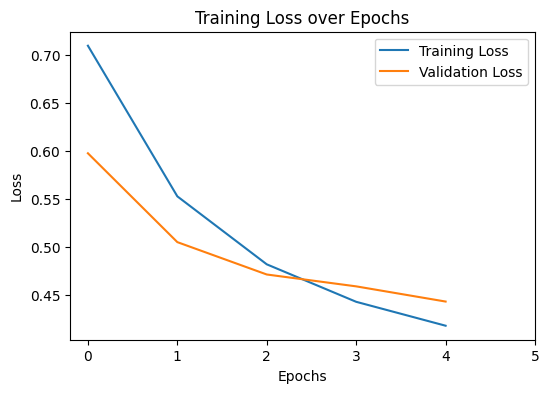

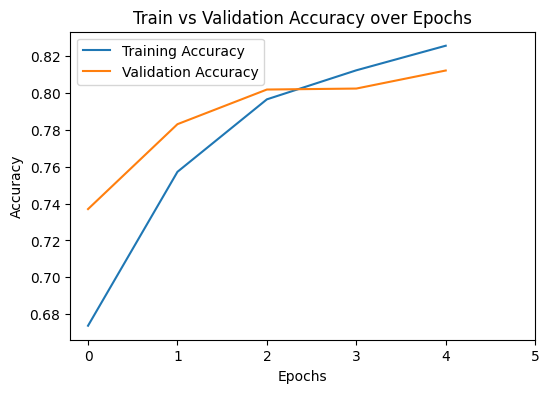

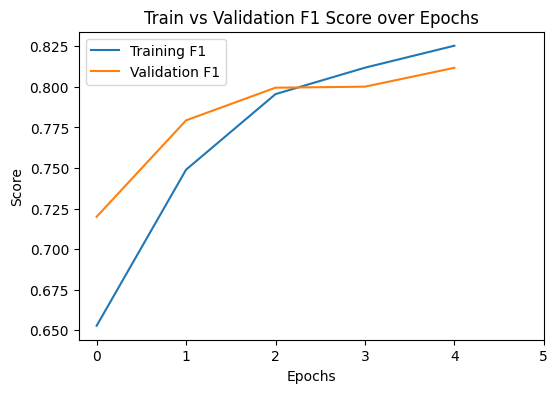

In [204]:
# Plots
import matplotlib.pyplot as plt

# Training vs Validation Loss
plt.figure(figsize=(6,4))
plt.plot(tr_loss, label='Training Loss')
plt.plot(v_loss, label='Validation Loss')
plt.xticks(range(0, 6, 1)) 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(6,4))
plt.plot(ac, label='Training Accuracy')
plt.plot(vac, label='Validation Accuracy')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(6,4))
plt.plot(f, label='Training F1')
plt.plot(vf, label='Validation F1')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Train vs Validation F1 Score over Epochs')
plt.legend()
plt.show()


Text only BERT model performance on test set

In [205]:
# collect predictions and labels
all_preds, all_labels = [], []
test_loss, test_acc, test_f1 = evaluate_text_model(text_model, test_text_loader)
print("Perfromance of Text only BERT model on test data:")
print(f"Test loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, F1: {test_f1:.4f}")

Perfromance of Text only BERT model on test data:
Test loss: 0.4503, Accuracy: 0.8081, F1: 0.8073


Save BERT model for fusion later

In [206]:
torch.save(text_model.state_dict(), "bert_text_only.pt")

Train Image only ResNet model

In [193]:
def evaluate_image_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1

In [194]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []

def train_image_model(model, train_loader, val_loader, epochs=5, lr=1e-5): # reduced learning rate
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4) # added weight decay

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Acc: {acc:.4f}, F1: {f1:.4f}")

        vloss, vacc, vf1 = evaluate_image_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, F1: {vf1:.4f}")
    return model

In [195]:
image_model = ImageClassifier().to(device)
image_model = train_image_model(image_model, train_image_loader, val_image_loader)

Epoch 1: 100%|██████████| 1886/1886 [1:30:39<00:00,  2.88s/it]


Epoch 1 | Train Loss: 0.7752, Acc: 0.5967, F1: 0.5644
Validation Loss: 0.6866, Accuracy: 0.6469, F1: 0.6201


Epoch 2: 100%|██████████| 1886/1886 [1:36:52<00:00,  3.08s/it]


Epoch 2 | Train Loss: 0.6690, Acc: 0.6631, F1: 0.6473
Validation Loss: 0.6548, Accuracy: 0.6752, F1: 0.6522


Epoch 3: 100%|██████████| 1886/1886 [1:22:06<00:00,  2.61s/it]


Epoch 3 | Train Loss: 0.6324, Acc: 0.6857, F1: 0.6764
Validation Loss: 0.6397, Accuracy: 0.6858, F1: 0.6685


Epoch 4: 100%|██████████| 1886/1886 [1:21:21<00:00,  2.59s/it]


Epoch 4 | Train Loss: 0.6058, Acc: 0.7028, F1: 0.6954
Validation Loss: 0.6402, Accuracy: 0.6970, F1: 0.6797


Epoch 5: 100%|██████████| 1886/1886 [1:23:56<00:00,  2.67s/it]


Epoch 5 | Train Loss: 0.5841, Acc: 0.7180, F1: 0.7111
Validation Loss: 0.6356, Accuracy: 0.6975, F1: 0.6797


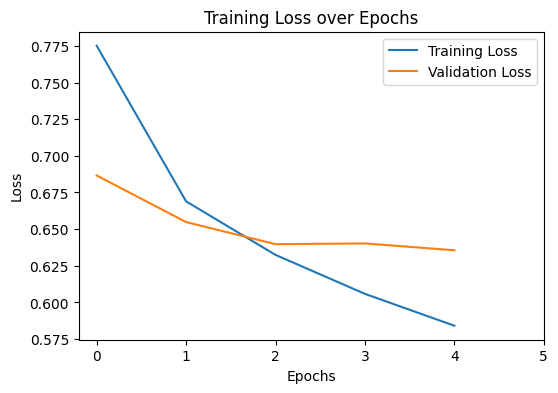

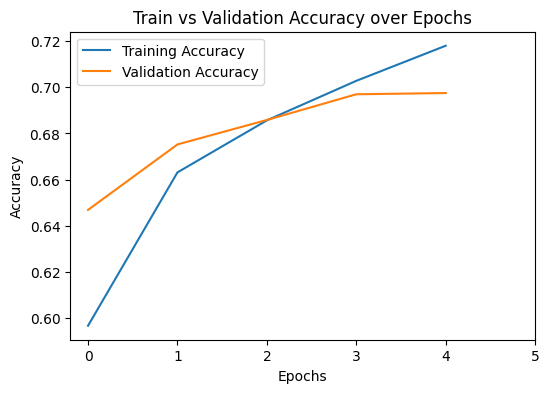

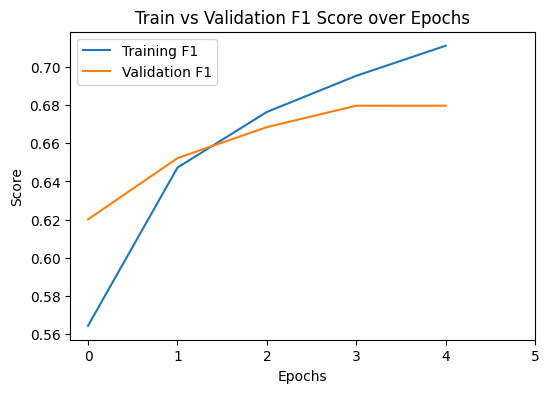

In [196]:
# plot loss, accuracy, f1
# Training vs Validation Loss
plt.figure(figsize=(6,4))
plt.plot(tr_loss, label='Training Loss')
plt.plot(v_loss, label='Validation Loss')
plt.xticks(range(0, 6, 1)) 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(6,4))
plt.plot(ac, label='Training Accuracy')
plt.plot(vac, label='Validation Accuracy')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(6,4))
plt.plot(f, label='Training F1')
plt.plot(vf, label='Validation F1')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Train vs Validation F1 Score over Epochs')
plt.legend()
plt.show()

Image only ResNet performance on test data

In [197]:
# collect predictions and labels
all_preds, all_labels = [], []
tloss, tacc, tf1 = evaluate_image_model(image_model, test_image_loader)
print("Perfromance of Image only ResNet model on test data:")
print(f"Test loss: {tloss:.4f}, Accuracy: {tacc:.4f}, F1: {tf1:.4f}")

Perfromance of Image only ResNet model on test data:
Test loss: 0.6329, Accuracy: 0.6980, F1: 0.6832


save image only ResNet model

In [198]:
torch.save(image_model.state_dict(), "resnet_image_only.pt")

Train BERT and ResNet Fusion model

In [207]:
def evaluate_fusion_model(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1

In [208]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []
def train_fusion_model(model, train_loader, val_loader, epochs=5, lr=1e-6): # reduced learning rate
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-4) # added weight decay

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Fusion Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Acc: {acc:.4f}, F1: {f1:.4f}")

        vloss, vacc, vf1 = evaluate_fusion_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, F1: {vf1:.4f}")
        print(f"Current α: {fusion_model.alpha.item():.3f}")
    return model

In [209]:
fusion_model = BertResNetLateFusion(
    text_model_path="bert_text_only.pt",
    image_model_path="resnet_image_only.pt",
    num_classes=3,
    freeze_encoders=True 
)

fusion_model = train_fusion_model(fusion_model, train_loader, val_loader)

Loaded pretrained BERT weights
Loaded pretrained ResNet weights


Fusion Epoch 1: 100%|██████████| 1886/1886 [1:28:51<00:00,  2.83s/it]


Epoch 1 | Train Loss: 0.6497, Acc: 0.7709, F1: 0.7603
Validation Loss: 0.4986, Accuracy: 0.7922, F1: 0.7861
Current α: 0.501


Fusion Epoch 2: 100%|██████████| 1886/1886 [1:29:44<00:00,  2.85s/it]


Epoch 2 | Train Loss: 0.4355, Acc: 0.8277, F1: 0.8264
Validation Loss: 0.4668, Accuracy: 0.8104, F1: 0.8089
Current α: 0.502


Fusion Epoch 3: 100%|██████████| 1886/1886 [1:29:58<00:00,  2.86s/it]


Epoch 3 | Train Loss: 0.4089, Acc: 0.8361, F1: 0.8358
Validation Loss: 0.4604, Accuracy: 0.8099, F1: 0.8082
Current α: 0.502


Fusion Epoch 4: 100%|██████████| 1886/1886 [1:29:26<00:00,  2.85s/it]


Epoch 4 | Train Loss: 0.4028, Acc: 0.8372, F1: 0.8370
Validation Loss: 0.4532, Accuracy: 0.8110, F1: 0.8096
Current α: 0.502


Fusion Epoch 5: 100%|██████████| 1886/1886 [1:38:17<00:00,  3.13s/it]


Epoch 5 | Train Loss: 0.3991, Acc: 0.8371, F1: 0.8368
Validation Loss: 0.4518, Accuracy: 0.8097, F1: 0.8084
Current α: 0.503


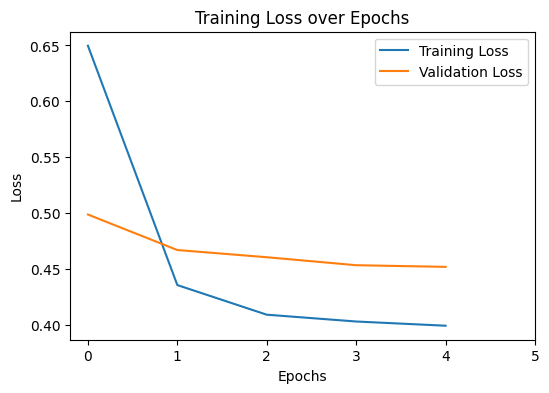

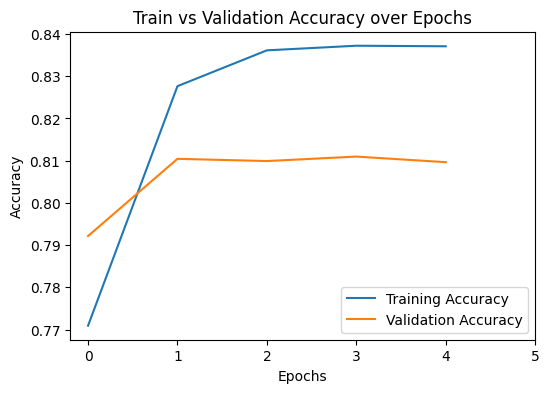

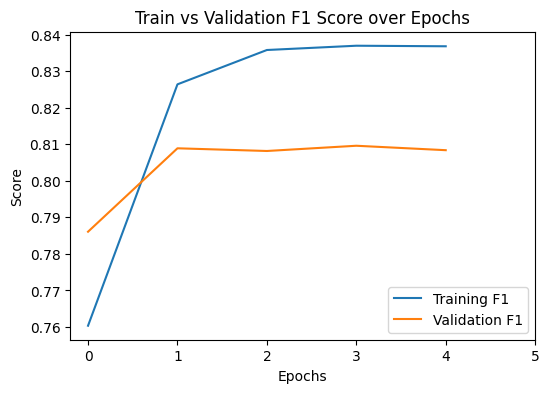

In [210]:
# plot loss, accuracy, f1
# Training vs Validation Loss
plt.figure(figsize=(6,4))
plt.plot(tr_loss, label='Training Loss')
plt.plot(v_loss, label='Validation Loss')
plt.xticks(range(0, 6, 1)) 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(6,4))
plt.plot(ac, label='Training Accuracy')
plt.plot(vac, label='Validation Accuracy')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(6,4))
plt.plot(f, label='Training F1')
plt.plot(vf, label='Validation F1')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Train vs Validation F1 Score over Epochs')
plt.legend()
plt.show()

BERT-ResNet fusion model perfromance on test data

In [211]:
# collect predictions and labels
all_preds, all_labels = [], []
tloss, tacc, tf1 = evaluate_fusion_model(fusion_model, test_loader)
print("Perfromance of Image and Text BERT-ResNet Fusion model on test data:")
print(f"Test loss: {tloss:.4f}, Accuracy: {tacc:.4f}, F1: {tf1:.4f}")

Perfromance of Image and Text BERT-ResNet Fusion model on test data:
Test loss: 0.4573, Accuracy: 0.8110, F1: 0.8092


In [212]:
import seaborn as sns
# define label names
label_names = ['True', 'Misleading', 'Fake']

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# collect predictions and labels
all_preds, all_labels = [], []
loop = tqdm(test_loader, desc='Testing')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        logits = model(batch["input_ids"], batch["attention_mask"], batch["image"])
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["label"].cpu().numpy())
# print classification report
report = classification_report(all_l, all_p, target_names=label_names, digits=4)
print('\n=== Classification Report (Full Fine-tuning) ===\n')
print(report)

Testing: 100%|██████████| 236/236 [11:25<00:00,  2.90s/it]


=== Classification Report (Full Fine-tuning) ===

              precision    recall  f1-score   support

        True     0.7950    0.8689    0.8303     37458
  Misleading     0.8761    0.7238    0.7927      2433
        Fake     0.7865    0.7007    0.7412     28005

    accuracy                         0.7943     67896
   macro avg     0.8192    0.7645    0.7881     67896
weighted avg     0.7944    0.7943    0.7922     67896



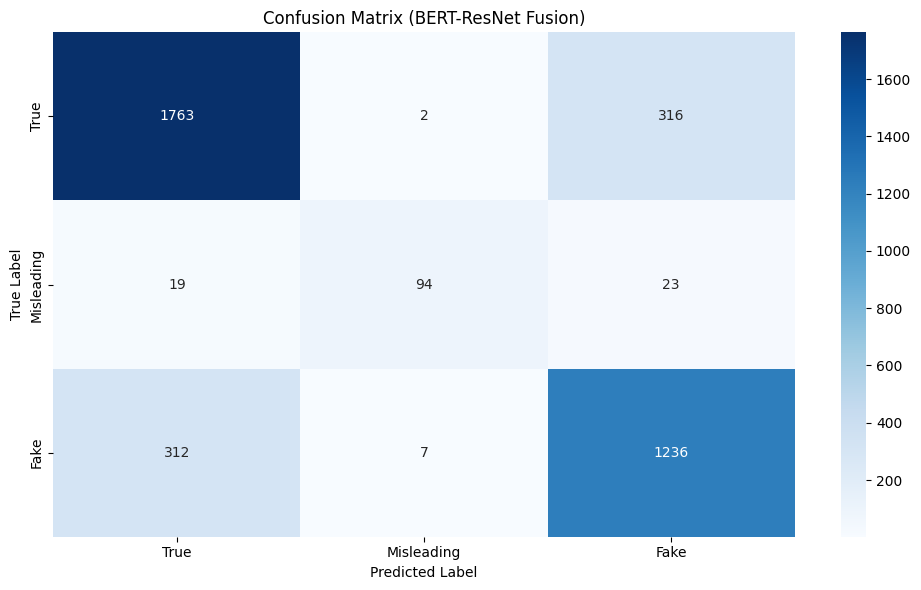

In [213]:
# plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (BERT-ResNet Fusion)')
plt.tight_layout()
plt.show()

Plot ROC-AUC curves

In [214]:
# binarize labels for ROC and precision-recall curves
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

# get prediction probabilities
all_probs = []
loop = tqdm(test_loader, desc='Collecting probabilities')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        logits = model(batch["input_ids"], batch["attention_mask"], batch["image"])
        probs = torch.softmax(logits, dim=-1)
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)

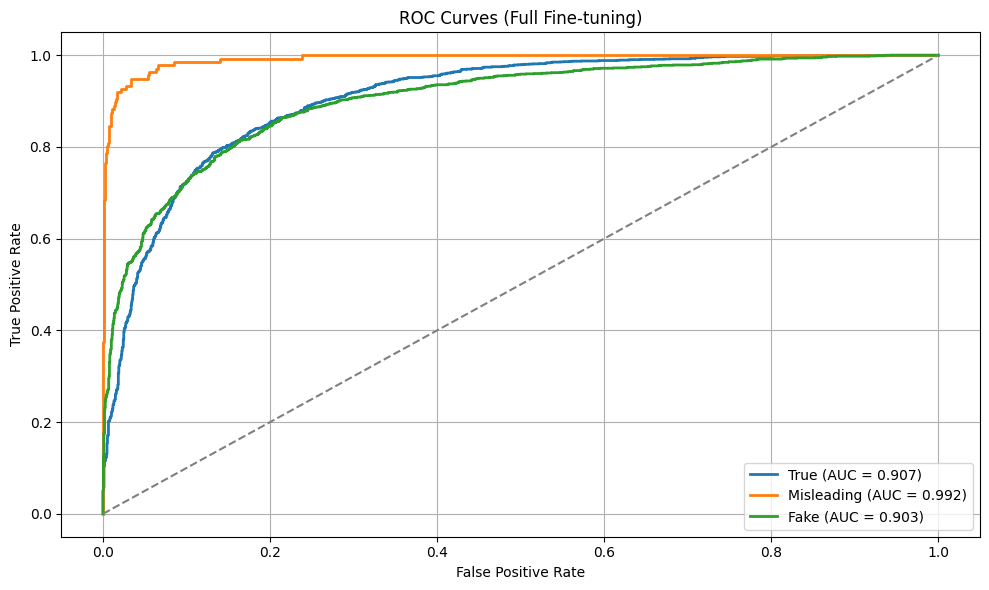

In [215]:
# plot ROC curves
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{name} (AUC = {roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Full Fine-tuning)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Plot precision-recall curves

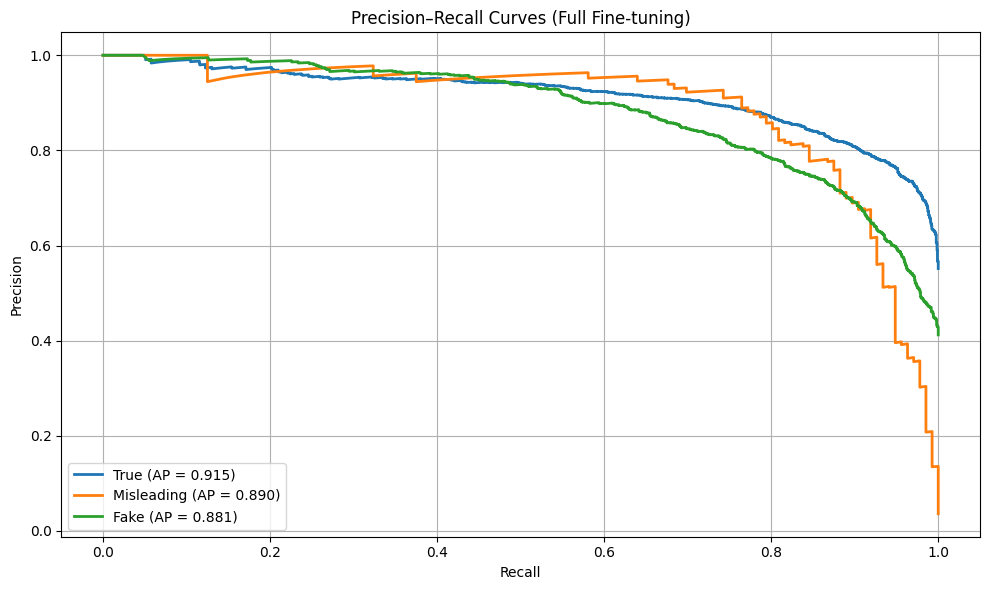

In [216]:
# plot precision-recall curves
precision, recall, avg_precision = {}, {}, {}
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], all_probs[:, i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(recall[i], precision[i], lw=2, label=f"{name} (AP = {avg_precision[i]:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Full Fine-tuning)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

Save BERT-ResNet fusion model

In [217]:
torch.save(fusion_model.state_dict(), "bert_resnet_fusion.pt")

Ablation: dropout = 0.3

BERT model

In [218]:
class TextClassifier(nn.Module):
    def __init__(self, text_model_name="bert-base-uncased", num_labels=3, freeze_bert=False):
        super().__init__()
        self.bert = BertModel.from_pretrained(text_model_name)
        self.config = self.bert.config  
        hidden = self.bert.config.hidden_size
        self.classifier = nn.Linear(hidden, num_labels)

        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        return self.classifier(pooled)

# LoRA config
config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    r=8,
    lora_alpha=32,
    lora_dropout=0.3,
    target_modules=["query", "value"]
)

# apply LoRA to BERT first, not to classifier
bert = BertModel.from_pretrained("bert-base-uncased")
bert = get_peft_model(bert, config)

# wrap the LoRA-BERT in classifier
text_model = TextClassifier(num_labels=3)
text_model.bert = bert


ResNet model

In [219]:
class ImageClassifier(nn.Module):
    def __init__(self, num_labels=3):
        super().__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        in_feat = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_feat, num_labels)
        )
        
        # Freeze all params
        for p in self.backbone.parameters():
            p.requires_grad = False

        # Unfreeze last residual block
        for name, p in self.backbone.layer4.named_parameters():
            p.requires_grad = True
        # Unfreeze final classifier
        for p in self.backbone.fc.parameters():
            p.requires_grad = True

    def forward(self, image):
        return self.backbone(image)


Fusion

In [220]:

class BertResNetLateFusion(nn.Module):
    def __init__(self, 
                 text_model_path="bert_text_only.pt", 
                 image_model_path="resnet_image_only.pt", 
                 num_classes=3, 
                 freeze_encoders=True):
        super().__init__()
        self.text_dropout = nn.Dropout(0.3)  
        self.img_dropout = nn.Dropout(0.3)

        # Load pretrained BERT
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.text_fc = nn.Linear(768, 512)  # reduce to 512-dim

        if text_model_path:
            try:
                text_state = torch.load(text_model_path, map_location="cpu")
                # Load only BERT weights (not classifier)
                bert_weights = {k.replace('bert.', ''): v for k, v in text_state.items() if 'bert.' in k}
                self.bert.load_state_dict(bert_weights, strict=False)
                print("Loaded pretrained BERT weights")
            except Exception as e:
                print(f"Could not load BERT weights: {e}")

        # Load pretrained ResNet
        resnet = models.resnet50(weights=None)
        resnet.fc = nn.Identity()
        self.resnet = resnet
        self.img_fc = nn.Linear(2048, 512)

        if image_model_path:
            try:
                image_state = torch.load(image_model_path, map_location="cpu")
                resnet_weights = {k.replace('resnet.', ''): v for k, v in image_state.items() if 'resnet.' in k}
                self.resnet.load_state_dict(resnet_weights, strict=False)
                print("Loaded pretrained ResNet weights")
            except Exception as e:
                print(f"Could not load ResNet weights: {e}")

        # Freeze fine-tuned encoders
        if freeze_encoders:
            for p in self.bert.parameters():
                p.requires_grad = False
            for p in self.resnet.parameters():
                p.requires_grad = False

            # Unfreeze last layers
            for name, param in self.bert.named_parameters():
                if "encoder.layer.11" in name or "pooler" in name:
                    param.requires_grad = True

            for name, param in self.resnet.named_parameters():
                if "layer4" in name:
                    param.requires_grad = True

        # Fusion head
        self.alpha = nn.Parameter(torch.tensor(0.5))  # learnable fusion weight
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    # Forward pass
    def forward(self, input_ids, attention_mask, image):
        # Text embedding
        text_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_emb = self.text_fc(text_out.pooler_output)
        text_emb = self.text_dropout(text_emb)

        # Image embedding
        img_emb = self.img_fc(self.resnet(image))
        img_emb = self.img_dropout(img_emb)

        # Weighted fusion
        fused_emb = self.alpha * text_emb + (1 - self.alpha) * img_emb
        logits = self.classifier(fused_emb)
        return logits


Train BERT

In [221]:
def evaluate_text_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_p.extend(preds.cpu().numpy())
            all_l.extend(batch["label"].cpu().numpy())
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1


In [222]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []

def train_text_model(model, train_loader, val_loader, epochs=5, lr=1e-6): # decreased learning rate
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}")
        
        vloss, vacc, vf1 = evaluate_text_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, F1: {vf1:.4f}")
    return model


In [223]:

text_model = TextClassifier().to(device)
text_model = train_text_model(text_model, train_text_loader, val_text_loader)

Epoch 1: 100%|██████████| 1886/1886 [28:21<00:00,  1.11it/s]


Epoch 1 | Train Loss: 0.7021, Accuracy: 0.6694, F1: 0.6493
Validation Loss: 0.5546, Accuracy: 0.7572, F1: 0.7521


Epoch 2: 100%|██████████| 1886/1886 [24:47<00:00,  1.27it/s]


Epoch 2 | Train Loss: 0.5275, Accuracy: 0.7683, F1: 0.7662
Validation Loss: 0.4919, Accuracy: 0.7898, F1: 0.7871


Epoch 3: 100%|██████████| 1886/1886 [25:45<00:00,  1.22it/s]


Epoch 3 | Train Loss: 0.4745, Accuracy: 0.7945, F1: 0.7937
Validation Loss: 0.4720, Accuracy: 0.7980, F1: 0.7950


Epoch 4: 100%|██████████| 1886/1886 [25:41<00:00,  1.22it/s]


Epoch 4 | Train Loss: 0.4422, Accuracy: 0.8123, F1: 0.8117
Validation Loss: 0.4570, Accuracy: 0.8065, F1: 0.8050


Epoch 5: 100%|██████████| 1886/1886 [25:32<00:00,  1.23it/s]


Epoch 5 | Train Loss: 0.4147, Accuracy: 0.8247, F1: 0.8243
Validation Loss: 0.4509, Accuracy: 0.8091, F1: 0.8076


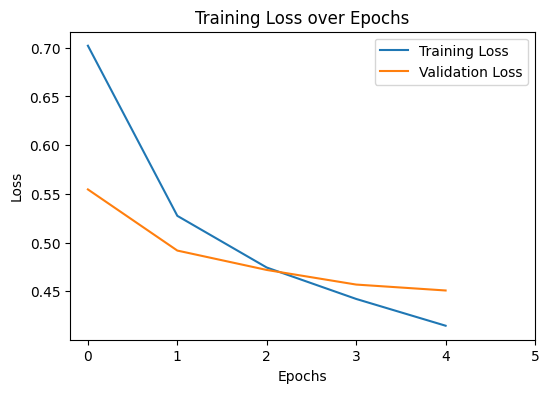

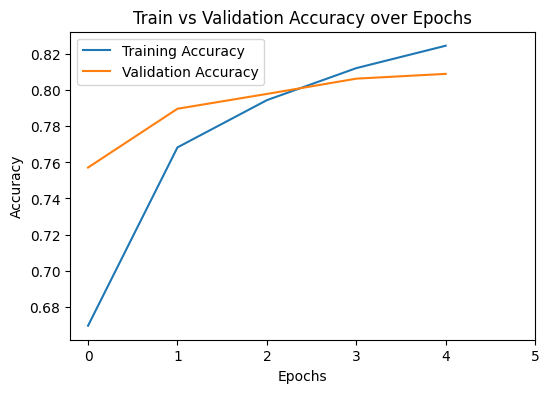

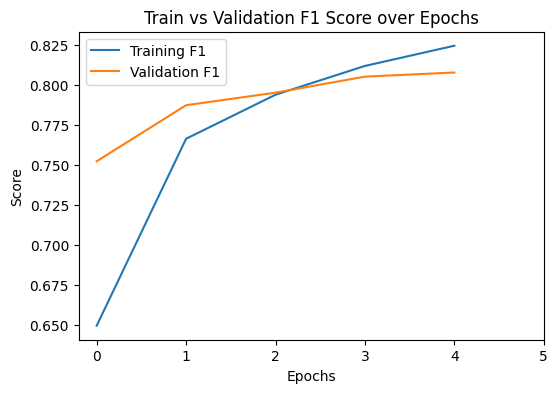

In [224]:
# Plots
import matplotlib.pyplot as plt

# Training vs Validation Loss
plt.figure(figsize=(6,4))
plt.plot(tr_loss, label='Training Loss')
plt.plot(v_loss, label='Validation Loss')
plt.xticks(range(0, 6, 1)) 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(6,4))
plt.plot(ac, label='Training Accuracy')
plt.plot(vac, label='Validation Accuracy')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(6,4))
plt.plot(f, label='Training F1')
plt.plot(vf, label='Validation F1')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Train vs Validation F1 Score over Epochs')
plt.legend()
plt.show()


BERT perfromance on Test set

In [225]:
# collect predictions and labels
all_preds, all_labels = [], []
test_loss, test_acc, test_f1 = evaluate_text_model(text_model, test_text_loader)
print("Perfromance of Text only BERT model on test data:")
print(f"Test loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, F1: {test_f1:.4f}")

Perfromance of Text only BERT model on test data:
Test loss: 0.4594, Accuracy: 0.8043, F1: 0.8024


svae bert model for later

In [226]:
torch.save(text_model.state_dict(), "bert_text_only2.pt")

Train ResNet

In [227]:
def evaluate_image_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1

In [228]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []

def train_image_model(model, train_loader, val_loader, epochs=5, lr=1e-5): # reduced learning rate
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4) # added weight decay

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Acc: {acc:.4f}, F1: {f1:.4f}")

        vloss, vacc, vf1 = evaluate_image_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, F1: {vf1:.4f}")
    return model

In [229]:
image_model = ImageClassifier().to(device)
image_model = train_image_model(image_model, train_image_loader, val_image_loader)

Epoch 1: 100%|██████████| 1886/1886 [1:37:47<00:00,  3.11s/it]


Epoch 1 | Train Loss: 0.7700, Acc: 0.5992, F1: 0.5697
Validation Loss: 0.6906, Accuracy: 0.6448, F1: 0.6124


Epoch 2: 100%|██████████| 1886/1886 [1:38:02<00:00,  3.12s/it]


Epoch 2 | Train Loss: 0.6713, Acc: 0.6595, F1: 0.6459
Validation Loss: 0.6502, Accuracy: 0.6808, F1: 0.6600


Epoch 3: 100%|██████████| 1886/1886 [1:36:59<00:00,  3.09s/it]


Epoch 3 | Train Loss: 0.6345, Acc: 0.6827, F1: 0.6733
Validation Loss: 0.6386, Accuracy: 0.6962, F1: 0.6806


Epoch 4: 100%|██████████| 1886/1886 [1:34:13<00:00,  3.00s/it]


Epoch 4 | Train Loss: 0.6127, Acc: 0.6979, F1: 0.6897
Validation Loss: 0.6283, Accuracy: 0.6999, F1: 0.6872


Epoch 5: 100%|██████████| 1886/1886 [1:25:07<00:00,  2.71s/it]


Epoch 5 | Train Loss: 0.5899, Acc: 0.7108, F1: 0.7040
Validation Loss: 0.6315, Accuracy: 0.6964, F1: 0.6855


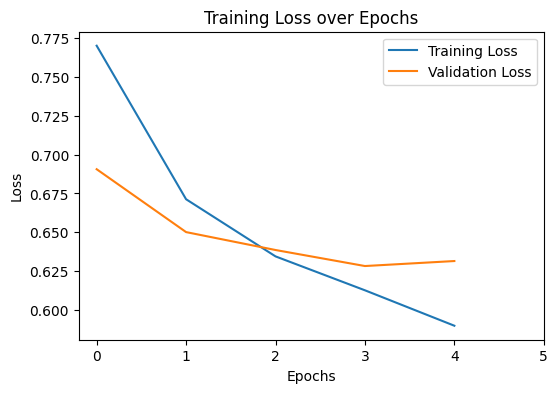

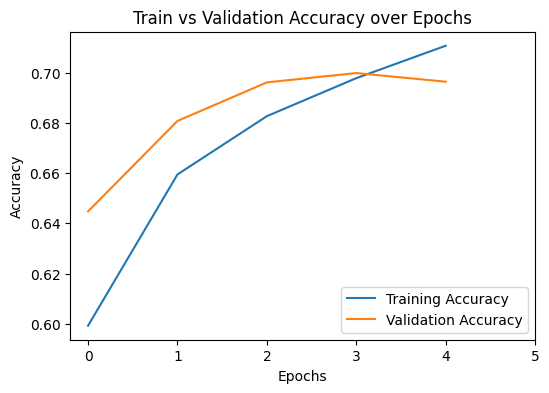

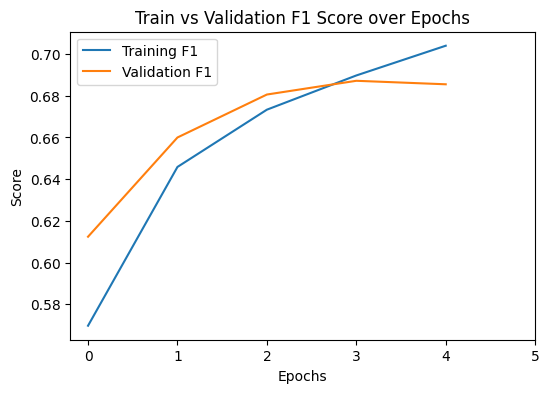

In [230]:
# plot loss, accuracy, f1
# Training vs Validation Loss
plt.figure(figsize=(6,4))
plt.plot(tr_loss, label='Training Loss')
plt.plot(v_loss, label='Validation Loss')
plt.xticks(range(0, 6, 1)) 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(6,4))
plt.plot(ac, label='Training Accuracy')
plt.plot(vac, label='Validation Accuracy')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(6,4))
plt.plot(f, label='Training F1')
plt.plot(vf, label='Validation F1')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Train vs Validation F1 Score over Epochs')
plt.legend()
plt.show()

ResNet performance on Test set

In [231]:
# collect predictions and labels
all_preds, all_labels = [], []
tloss, tacc, tf1 = evaluate_image_model(image_model, test_image_loader)
print("Perfromance of Image only ResNet model on test data:")
print(f"Test loss: {tloss:.4f}, Accuracy: {tacc:.4f}, F1: {tf1:.4f}")

Perfromance of Image only ResNet model on test data:
Test loss: 0.6183, Accuracy: 0.7017, F1: 0.6930


svae ResNet model

In [232]:
torch.save(image_model.state_dict(), "resnet_image_only2.pt")

Train fusion model

In [233]:
def evaluate_fusion_model(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1

In [234]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []
def train_fusion_model(model, train_loader, val_loader, epochs=5, lr=1e-6): # reduced learning rate
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-4) # added weight decay

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Fusion Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Acc: {acc:.4f}, F1: {f1:.4f}")

        vloss, vacc, vf1 = evaluate_fusion_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, F1: {vf1:.4f}")
        print(f"Current α: {fusion_model.alpha.item():.3f}")
    return model

In [235]:
fusion_model = BertResNetLateFusion(
    text_model_path="bert_text_only.pt",
    image_model_path="resnet_image_only.pt",
    num_classes=3,
    freeze_encoders=True 
)

fusion_model = train_fusion_model(fusion_model, train_loader, val_loader)

Loaded pretrained BERT weights
Loaded pretrained ResNet weights


Fusion Epoch 1: 100%|██████████| 1886/1886 [1:38:23<00:00,  3.13s/it]


Epoch 1 | Train Loss: 0.6444, Acc: 0.7683, F1: 0.7554
Validation Loss: 0.5043, Accuracy: 0.7802, F1: 0.7646
Current α: 0.501


Fusion Epoch 2: 100%|██████████| 1886/1886 [1:29:46<00:00,  2.86s/it]


Epoch 2 | Train Loss: 0.4406, Acc: 0.8247, F1: 0.8232
Validation Loss: 0.4707, Accuracy: 0.8086, F1: 0.8071
Current α: 0.502


Fusion Epoch 3: 100%|██████████| 1886/1886 [1:28:41<00:00,  2.82s/it]


Epoch 3 | Train Loss: 0.4118, Acc: 0.8355, F1: 0.8352
Validation Loss: 0.4630, Accuracy: 0.8097, F1: 0.8082
Current α: 0.503


Fusion Epoch 4: 100%|██████████| 1886/1886 [1:28:16<00:00,  2.81s/it]


Epoch 4 | Train Loss: 0.4052, Acc: 0.8367, F1: 0.8363
Validation Loss: 0.4616, Accuracy: 0.8094, F1: 0.8080
Current α: 0.503


Fusion Epoch 5: 100%|██████████| 1886/1886 [1:29:12<00:00,  2.84s/it]


Epoch 5 | Train Loss: 0.4036, Acc: 0.8361, F1: 0.8358
Validation Loss: 0.4575, Accuracy: 0.8078, F1: 0.8061
Current α: 0.503


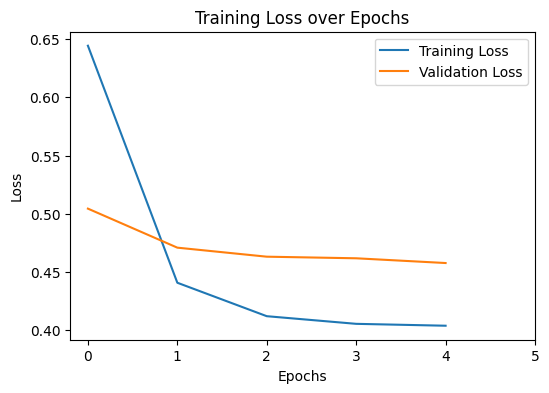

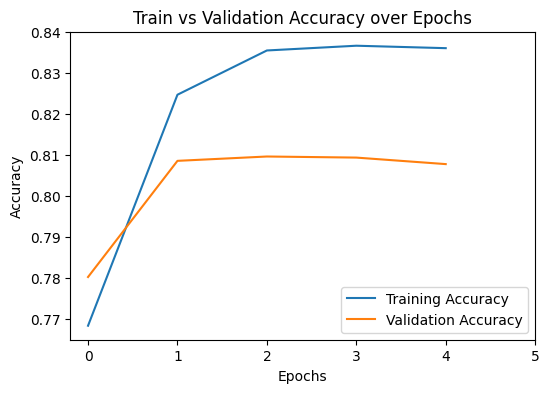

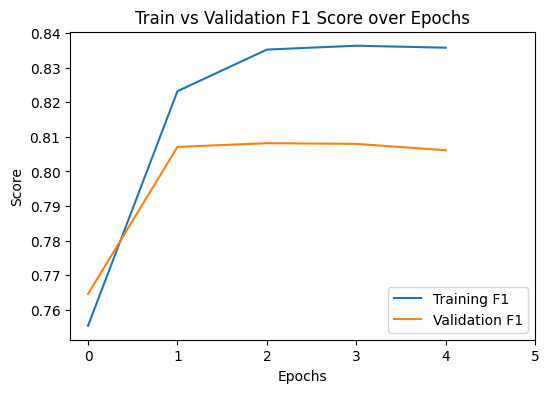

In [236]:
# plot loss, accuracy, f1
# Training vs Validation Loss
plt.figure(figsize=(6,4))
plt.plot(tr_loss, label='Training Loss')
plt.plot(v_loss, label='Validation Loss')
plt.xticks(range(0, 6, 1)) 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(6,4))
plt.plot(ac, label='Training Accuracy')
plt.plot(vac, label='Validation Accuracy')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(6,4))
plt.plot(f, label='Training F1')
plt.plot(vf, label='Validation F1')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Train vs Validation F1 Score over Epochs')
plt.legend()
plt.show()

Fusion model performance on test set

In [237]:
# collect predictions and labels
all_preds, all_labels = [], []
tloss, tacc, tf1 = evaluate_fusion_model(fusion_model, test_loader)
print("Perfromance of Image and Text BERT-ResNet Fusion model on test data:")
print(f"Test loss: {tloss:.4f}, Accuracy: {tacc:.4f}, F1: {tf1:.4f}")

Perfromance of Image and Text BERT-ResNet Fusion model on test data:
Test loss: 0.4631, Accuracy: 0.8078, F1: 0.8055


In [238]:
import seaborn as sns
# define label names
label_names = ['True', 'Misleading', 'Fake']

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# collect predictions and labels
all_preds, all_labels = [], []
loop = tqdm(test_loader, desc='Testing')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        logits = model(batch["input_ids"], batch["attention_mask"], batch["image"])
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["label"].cpu().numpy())
# print classification report
report = classification_report(all_l, all_p, target_names=label_names, digits=4)
print('\n=== Classification Report (Full Fine-tuning) ===\n')
print(report)

Testing: 100%|██████████| 236/236 [09:38<00:00,  2.45s/it]


=== Classification Report (Full Fine-tuning) ===

              precision    recall  f1-score   support

        True     0.7943    0.8700    0.8304     49944
  Misleading     0.8749    0.7284    0.7950      3244
        Fake     0.7877    0.6987    0.7405     37340

    accuracy                         0.7943     90528
   macro avg     0.8189    0.7657    0.7886     90528
weighted avg     0.7944    0.7943    0.7921     90528



Plot ROC-AUC curves

In [239]:
# binarize labels for ROC and precision-recall curves
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

# get prediction probabilities
all_probs = []
loop = tqdm(test_loader, desc='Collecting probabilities')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        logits = model(batch["input_ids"], batch["attention_mask"], batch["image"])
        probs = torch.softmax(logits, dim=-1)
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)

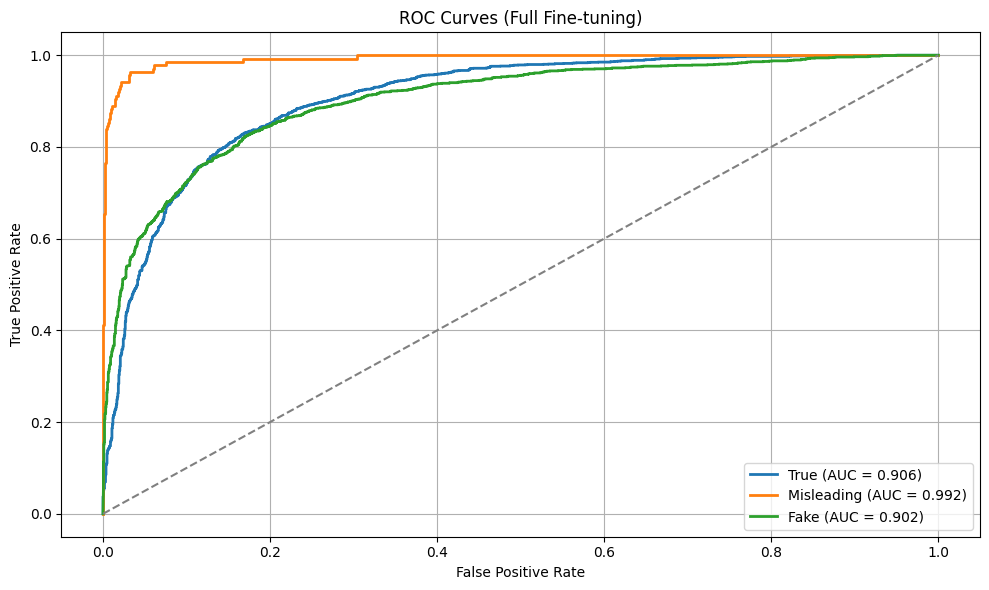

In [240]:
# plot ROC curves
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{name} (AUC = {roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Full Fine-tuning)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Plot precision-recall curves

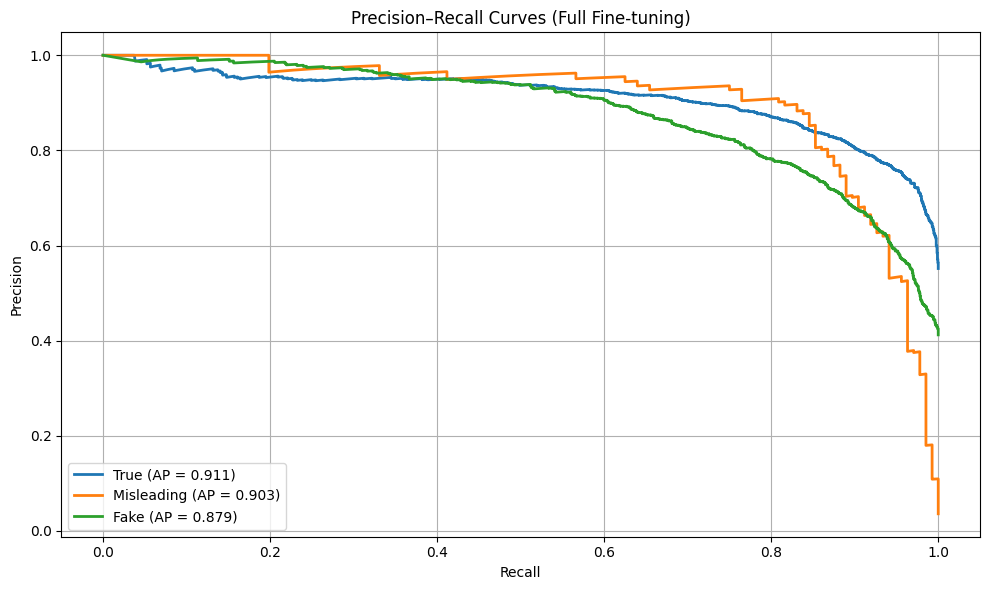

In [241]:
# plot precision-recall curves
precision, recall, avg_precision = {}, {}, {}
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], all_probs[:, i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(recall[i], precision[i], lw=2, label=f"{name} (AP = {avg_precision[i]:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Full Fine-tuning)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()